In [1]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

from torchvision import models
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
!cp "/content/drive/MyDrive/cifake-sub.zip" .
!cp "/content/drive/MyDrive/ps-battles-proc-sub.zip" .

In [5]:
!unzip -n "cifake-sub.zip" -d . > /dev/null
!unzip -n "ps-battles-proc-sub.zip" -d . > /dev/null

#### Read data

In [6]:
ps_battles_dir = 'ps-battles-proc-sub'
ci_fake_dir = 'cifake-sub'

In [7]:
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
])

test_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
])

data_transforms = {
    'train': train_transforms,
    'val': train_transforms,
    'test': test_transforms
}

In [8]:
class RenamedImageFolder(ImageFolder):
    def __init__(self, root, transform=None, class_mapping=None, class_indexes=None):
        self.class_mapping = class_mapping if class_mapping else {}
        super().__init__(root, transform=transform)

        if self.class_mapping:
            new_class_to_idx = {self.class_mapping.get(k, k): v for k, v in self.class_to_idx.items()}
            self.class_to_idx = new_class_to_idx
            self.classes = list(self.class_to_idx.keys())
            self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

            new_samples = []
            for path, label in self.samples:
                class_name = self.idx_to_class[label]
                new_label = self.class_to_idx[class_name]
                new_samples.append((path, new_label))
            self.samples = new_samples
            self.targets = [label for _, label in self.samples]

        if class_indexes:
            self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
            new_samples = []
            for path, label in self.samples:
                new_label = class_indexes[self.idx_to_class[label]]
                new_samples.append((path, new_label))
            self.samples = new_samples
            self.targets = [label for _, label in self.samples]

            self.class_to_idx = class_indexes
            self.idx_to_class = {v: k for k, v in class_indexes.items()}
            self.classes = list(class_indexes.keys())


    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        return image, label

In [9]:
class_indexes = {'real': 0, 'fake': 1}

ci_fake_dataset = {x: RenamedImageFolder(os.path.join(ci_fake_dir, x), data_transforms[x], class_indexes=class_indexes) for x in ['train', 'val', 'test']}
ci_fake_train_val = ConcatDataset([ci_fake_dataset['train'], ci_fake_dataset['val']])

print('Train Ci-fake dataset size:', len(ci_fake_dataset['train']))
print('Val Ci-fake dataset size:', len(ci_fake_dataset['val']))
print('Train + Val Ci-fake dataset size:', len(ci_fake_train_val))
print('Test Ci-fake dataset size:', len(ci_fake_dataset['test']))

Train Ci-fake dataset size: 16000
Val Ci-fake dataset size: 4000
Train + Val Ci-fake dataset size: 20000
Test Ci-fake dataset size: 4000


In [10]:
print("Class to Index Mapping:", ci_fake_dataset['train'].class_to_idx)

Class to Index Mapping: {'real': 0, 'fake': 1}


In [11]:
ci_fake_classes = ci_fake_dataset['train'].classes

In [12]:
class_indexes = {'real': 0, 'fake': 1}

ps_battles_dataset = {x: RenamedImageFolder(os.path.join(ps_battles_dir, x), data_transforms[x], class_indexes=class_indexes) for x in ['train', 'val', 'test']}
ps_battles_train_val = ConcatDataset([ps_battles_dataset['train'], ps_battles_dataset['val']])

print('Train Ps-battles dataset size:', len(ps_battles_dataset['train']))
print('Val Ps-battles dataset size:', len(ps_battles_dataset['val']))
print('Train + Val Ps-battles dataset size:', len(ps_battles_train_val))
print('Test Ps-battles dataset size:', len(ps_battles_dataset['test']))

Train Ps-battles dataset size: 12368
Val Ps-battles dataset size: 3091
Train + Val Ps-battles dataset size: 15459
Test Ps-battles dataset size: 3865


In [13]:
print("Class to Index Mapping:", ps_battles_dataset['train'].class_to_idx)

Class to Index Mapping: {'real': 0, 'fake': 1}


In [14]:
ps_battles_classes = ps_battles_dataset['train'].classes

In [15]:
full_dataset_train_two_classes = ConcatDataset([ci_fake_dataset['train'], ps_battles_dataset['train']])
full_dataset_val_two_classes = ConcatDataset([ci_fake_dataset['val'], ps_battles_dataset['val']])
full_dataset_test_two_classes = ConcatDataset([ci_fake_dataset['test'], ps_battles_dataset['test']])
full_dataset_train_val_two_classes = ConcatDataset([full_dataset_train_two_classes, full_dataset_val_two_classes])

print('Train full dataset size:', len(full_dataset_train_two_classes))
print('Val full dataset size:', len(full_dataset_val_two_classes))
print('Train + Val full dataset size:', len(full_dataset_train_val_two_classes))
print('Test full dataset size:', len(full_dataset_test_two_classes))

Train full dataset size: 28368
Val full dataset size: 7091
Train + Val full dataset size: 35459
Test full dataset size: 7865


In [16]:
print("Class to Index Mapping:", full_dataset_train_two_classes.datasets[0].class_to_idx)
print("Class to Index Mapping:", full_dataset_train_two_classes.datasets[1].class_to_idx)

Class to Index Mapping: {'real': 0, 'fake': 1}
Class to Index Mapping: {'real': 0, 'fake': 1}


In [17]:
class_mapping = {'fake': 'edited'}
class_indexes = {'real': 0, 'edited': 1, 'synthetic': 2}
ps_battles_renamed_dataset = {x: RenamedImageFolder(os.path.join(ps_battles_dir, x), transform=data_transforms[x], class_mapping=class_mapping, class_indexes=class_indexes) for x in ['train', 'val', 'test']}
ps_battles_renamed_dataset_classes = ps_battles_renamed_dataset['train'].classes
ps_battles_renamed_dataset_classes

['real', 'edited', 'synthetic']

In [18]:
class_mapping = {'fake': 'synthetic'}
class_indexes = {'real': 0, 'edited': 1, 'synthetic': 2}
ci_fake_renamed_dataset = {x: RenamedImageFolder(os.path.join(ci_fake_dir, x), transform=data_transforms[x], class_mapping=class_mapping, class_indexes=class_indexes) for x in ['train', 'val', 'test']}
ci_fake_renamed_dataset_classes = ci_fake_renamed_dataset['train'].classes
ci_fake_renamed_dataset_classes

['real', 'edited', 'synthetic']

In [19]:
full_dataset_train_three_classes = ConcatDataset([ci_fake_renamed_dataset['train'], ps_battles_renamed_dataset['train']])
full_dataset_val_three_classes = ConcatDataset([ci_fake_renamed_dataset['val'], ps_battles_renamed_dataset['val']])
full_dataset_test_three_classes = ConcatDataset([ci_fake_renamed_dataset['test'], ps_battles_renamed_dataset['test']])
full_dataset_train_val_three_classes = ConcatDataset([full_dataset_train_three_classes, full_dataset_val_three_classes])

print('Train full dataset size:', len(full_dataset_train_three_classes))
print('Val full dataset size:', len(full_dataset_val_three_classes))
print('Train + Val full dataset size:', len(full_dataset_train_val_three_classes))
print('Test full dataset size:', len(full_dataset_test_three_classes))

Train full dataset size: 28368
Val full dataset size: 7091
Train + Val full dataset size: 35459
Test full dataset size: 7865


In [20]:
all_labels = [sample[1] for sample in full_dataset_train_val_three_classes]
class_counts = Counter(all_labels)
print("Class Distribution:", class_counts)

Class Distribution: Counter({1: 13821, 0: 11638, 2: 10000})


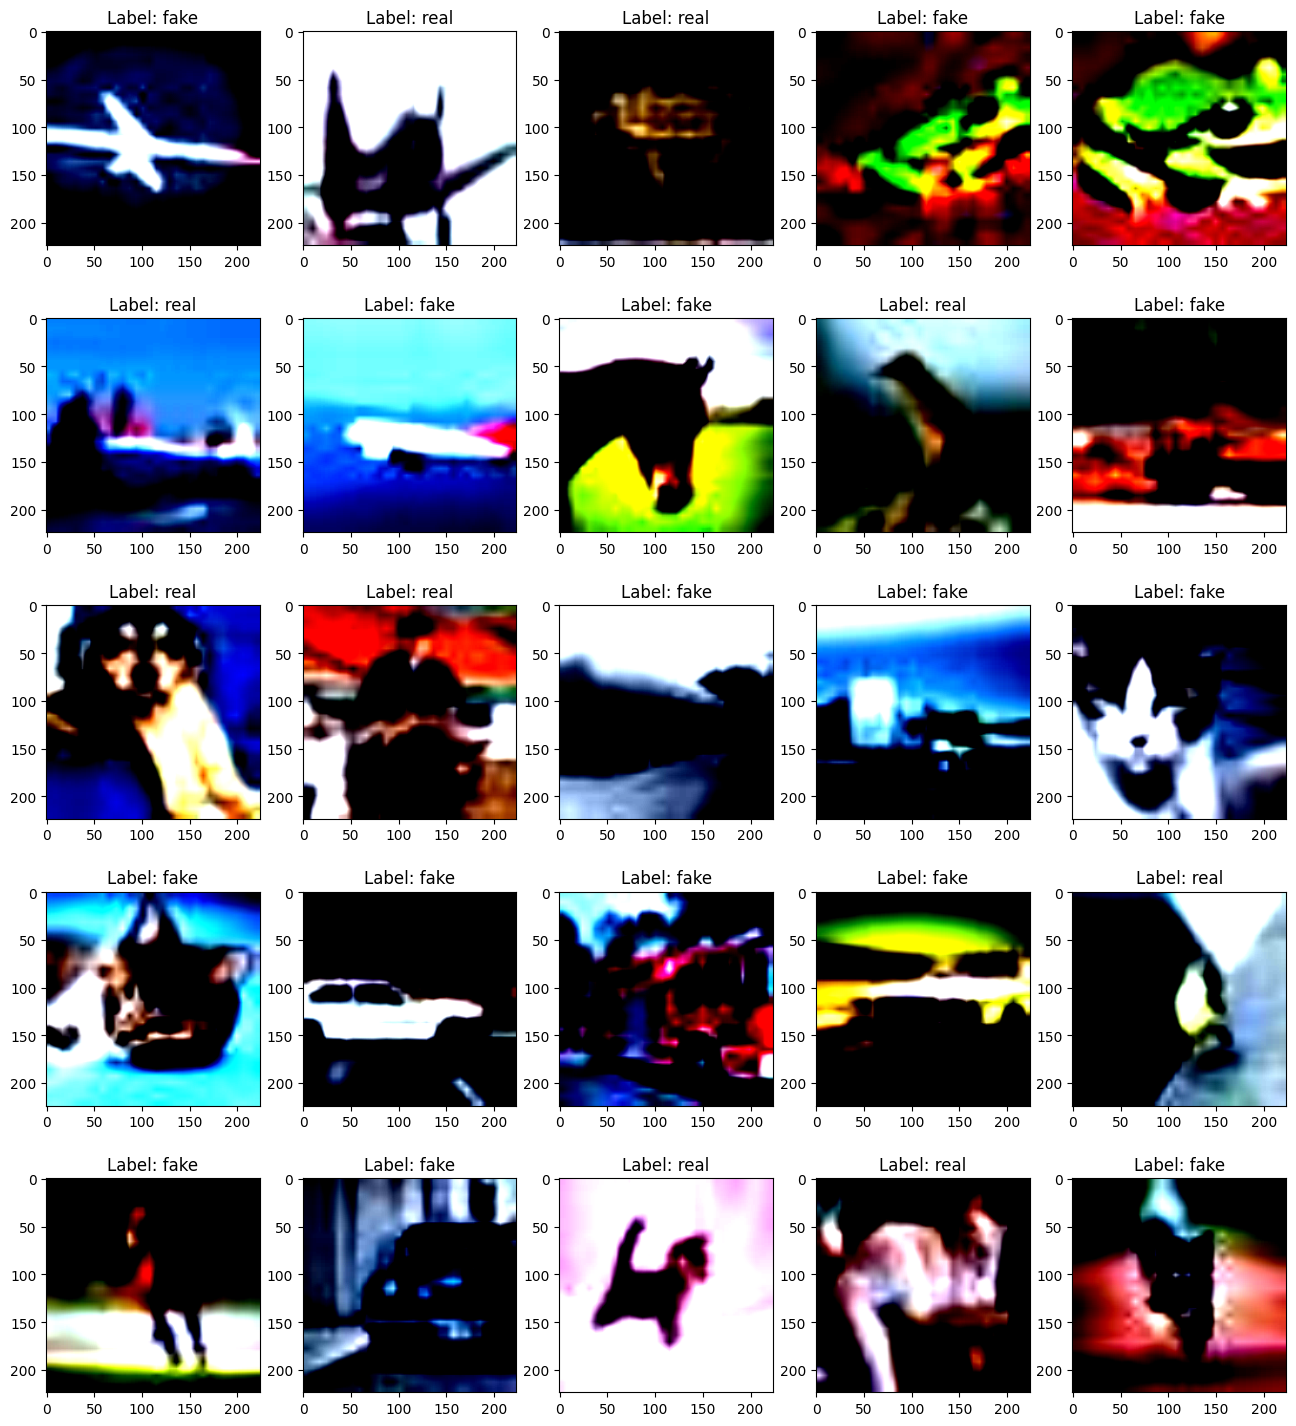

In [ ]:
N_IMAGES = 25
indices = random.sample(range(len(ci_fake_dataset['train'])), N_IMAGES)

plt.figure(figsize=(16, 18))
for i, idx in enumerate(indices):
  img = ci_fake_dataset['train'][idx][0].permute(1, 2, 0)
  img = torch.clamp(img, 0, 1)
  label = ci_fake_dataset['train'][idx][1]
  plt.subplot(5,5,i+1)
  plt.imshow(img)
  plt.title(f"Label: {ci_fake_classes[label]}")

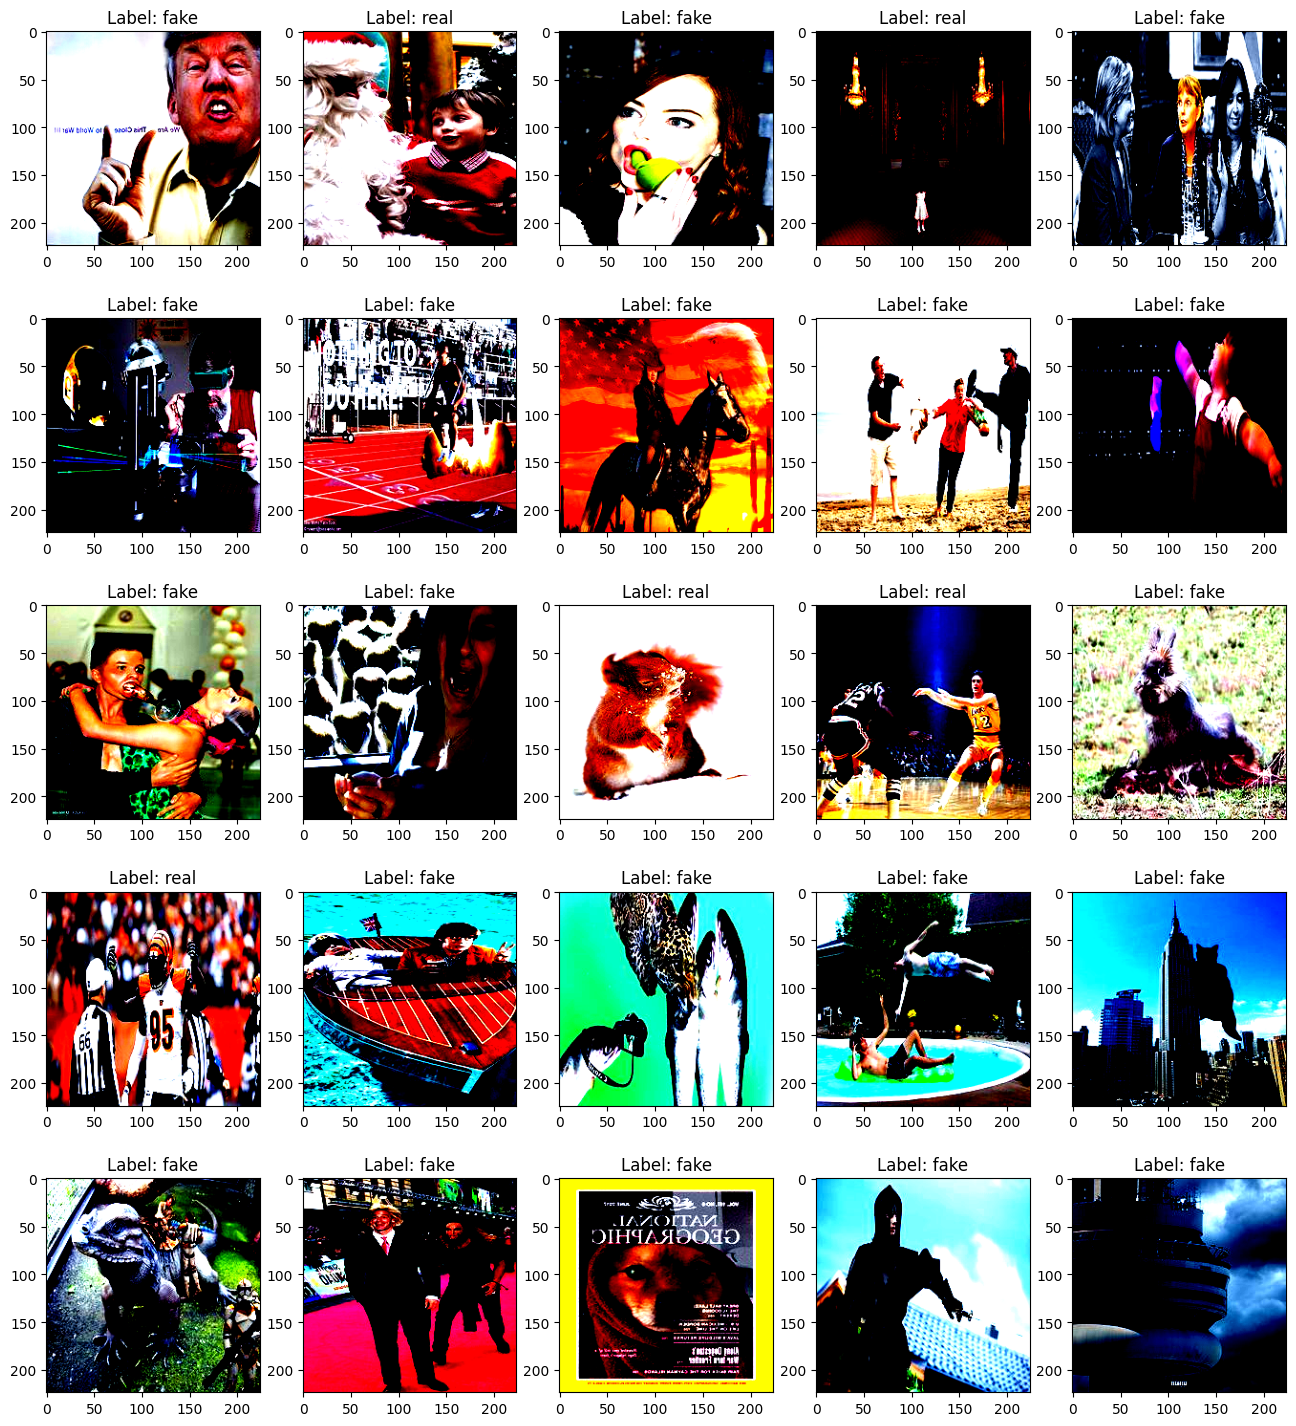

In [ ]:
N_IMAGES = 25
indices = random.sample(range(len(ps_battles_dataset['train'])), N_IMAGES)

plt.figure(figsize=(16, 18))
for i, idx in enumerate(indices):
  img = ps_battles_dataset['train'][idx][0].permute(1, 2, 0)
  img = torch.clamp(img, 0, 1)
  label = ps_battles_dataset['train'][idx][1]
  plt.subplot(5,5,i+1)
  plt.imshow(img)
  plt.title(f"Label: {ci_fake_classes[label]}")

### Models

In [21]:
def fit(model, train_dataloader, test_dataloader, epochs, optimizer, loss_function, print_losses=True, network_type='binary'):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(X_batch)

            if network_type == 'binary':
                y_batch = y_batch.float()
                y_pred = y_pred.squeeze()
            else:
                y_batch = y_batch.long()

            loss = loss_function(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_dataloader))

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model.forward(X_batch)

                if network_type == 'binary':
                    y_batch = y_batch.float()
                    y_pred = y_pred.squeeze()
                else:
                    y_batch = y_batch.long()

                loss = loss_function(y_pred, y_batch)
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_dataloader))

        if print_losses:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

def predict(model, dataloader, network_type='binary'):
    all_outputs = []
    model.eval()
    with torch.no_grad():
      for X_batch, _ in dataloader:
        X_batch = X_batch.to(device)
        outputs = model.forward(X_batch)

        if network_type == 'binary':
            outputs = torch.sigmoid(outputs)
            predicted = (outputs > 0.5).float()
        else:
            _, predicted = torch.max(outputs.data, 1)

        all_outputs.extend(predicted.cpu().numpy())
    return np.array(all_outputs)

In [22]:
def calculate_scores_binary(y_test, y_pred_tab, parameters):
    results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1'])

    for param in parameters:
        cm = confusion_matrix(y_test, y_pred_tab)
        print(f'Confusion Matrix for {param}:')
        print(cm, '\n')

        accuracy = round((accuracy_score(y_test, y_pred_tab)*100), 3)
        precision = round((precision_score(y_test, y_pred_tab)*100), 3)
        recall = round((recall_score(y_test, y_pred_tab)*100), 3)
        f1 = round((f1_score(y_test, y_pred_tab)*100), 3)
        results.loc[str(param)] = [accuracy, precision, recall, f1]

    return results

In [23]:
def calculate_scores_multi(y_test, y_pred_tab, labels):
    results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1'])

    cm = confusion_matrix(y_test, y_pred_tab, labels=labels)
    print('Confusion Matrix:')
    print(cm, '\n')

    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)

    recall = np.divide(tp, (tp + fn), out=np.zeros_like(tp, dtype=float), where=(tp + fn) != 0)
    precision = np.divide(tp, (tp + fp), out=np.zeros_like(tp, dtype=float), where=(tp + fp) != 0)
    f1 = np.divide(2 * (precision * recall), (precision + recall), out=np.zeros_like(tp, dtype=float), where=(precision + recall) != 0)

    per_class_accuracies = {}

    for idx, cls in enumerate(labels):
      true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
      true_positives = cm[idx, idx]
      per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)

    for label in labels:
        results.loc[label] = [round((per_class_accuracies[label]*100), 3),
                              round((precision[label]*100), 3),
                              round((recall[label]*100), 3),
                              round((f1[label]*100), 3)]

    results.loc['Average'] = round(results.mean(), 3)

    accuracy = round((accuracy_score(y_test, y_pred_tab)*100), 3)
    precision = round((precision_score(y_test, y_pred_tab, average='weighted')*100), 3)
    recall = round((recall_score(y_test, y_pred_tab, average='weighted')*100), 3)
    f1 = round((f1_score(y_test, y_pred_tab, average='weighted')*100), 3)
    results.loc['Overall'] = [accuracy, precision, recall, f1]

    return results

In [24]:
def calculate_class_weights(y):
    classes = np.unique(y)
    class_counts = np.bincount(y)
    quotients = len(y) / class_counts
    normalized_weights = quotients / quotients.sum()
    class_weights = {cls: weight for cls, weight in zip(classes, normalized_weights)}
    return class_weights

In [25]:
googlenet_model = models.googlenet(weights='IMAGENET1K_V1')

for param in googlenet_model.parameters():
    param.requires_grad = False

googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, 1)
googlenet_model = googlenet_model.to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 163MB/s]


In [26]:
vgg19_model = models.vgg19(weights='IMAGENET1K_V1')

for param in vgg19_model.parameters():
    param.requires_grad = False

vgg19_model.classifier[6] = nn.Linear(vgg19_model.classifier[6].in_features, 1)
vgg19_model = vgg19_model.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 177MB/s]


In [27]:
resnet50_model = models.resnet50(weights='IMAGENET1K_V1')

for param in resnet50_model.parameters():
    param.requires_grad = False

resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 1)

resnet50_model = resnet50_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


#### Validation

In [ ]:
def validate_hyperparams(model, model_type, train_dataset, val_dataset, hyperparam_grid, epochs, class_weights_tensor):
    learning_rates = hyperparam_grid.get("learning_rate")
    batch_sizes = hyperparam_grid.get("batch_size")
    optimizers = hyperparam_grid.get("optimizer")

    results = {}

    for lr, batch_size, opt in itertools.product(learning_rates, batch_sizes, optimizers):
        print(f"\nTesting LR={lr}, Batch Size={batch_size}, Optimizer={opt}")

        if model_type == 'googlenet':
            model.fc = nn.Linear(model.fc.in_features, 1)
            model = model.to(device)
        elif model_type == 'vgg19':
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)
            model = model.to(device)
        elif model_type == 'resnet50':
            model.fc = nn.Linear(model.fc.in_features, 1)
            model = model.to(device)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

        if opt == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif opt == 'Adagrad':
            optimizer = optim.Adagrad(model.parameters(), lr=lr)

        train_losses, val_losses = fit(model, train_dataloader, val_dataloader, epochs, optimizer, loss_function, print_losses=True)

        best_val_loss = min(val_losses)
        results[(lr, batch_size, opt)] = best_val_loss

    print("\n=== Hyperparameter Tuning Results ===")
    for key, loss in results.items():
        print(f"LR={key[0]}, Batch Size={key[1]}, Optimizer={key[2]} -> Best Val Loss: {loss:.4f}")

    best_hyperparams = min(results, key=results.get)
    print(f"\nBest Combination: LR={best_hyperparams[0]}, Batch Size={best_hyperparams[1]}, Optimizer={best_hyperparams[2]} with Loss={results[best_hyperparams]:.4f}")

    return best_hyperparams


In [ ]:
hyperparam_grid = {
    "learning_rate": [0.0001, 0.001],
    "batch_size": [32, 64],
    "optimizer": ["Adam", "Adagrad"]
}

In [ ]:
weights_all_two_classes = calculate_class_weights([sample[1] for sample in full_dataset_train_val_two_classes])
weights_all_two_classes

{0: 0.6717899545954482, 1: 0.32821004540455173}

In [ ]:
class_weights_tensor_all_two_classes = torch.tensor([weights_all_two_classes[1]/weights_all_two_classes[0]],
                                                    dtype=torch.float32).to(device)
class_weights_tensor_all_two_classes

tensor([0.4886], device='cuda:0')

In [ ]:
best_hyperparams_googlenet = validate_hyperparams(
    model=googlenet_model,
    model_type='googlenet',
    train_dataset=full_dataset_train_two_classes,
    val_dataset=full_dataset_val_two_classes,
    hyperparam_grid=hyperparam_grid,
    epochs=10,
    class_weights_tensor=class_weights_tensor_all_two_classes
)
best_lr_googlenet, best_batch_size_googlenet, best_opt_googlenet = best_hyperparams_googlenet


Testing LR=0.0001, Batch Size=32, Optimizer=Adam
Epoch 1/10 - Train Loss: 0.3828, Test Loss: 0.3388
Epoch 2/10 - Train Loss: 0.3272, Test Loss: 0.3107
Epoch 3/10 - Train Loss: 0.3077, Test Loss: 0.2938
Epoch 4/10 - Train Loss: 0.2984, Test Loss: 0.2849
Epoch 5/10 - Train Loss: 0.2915, Test Loss: 0.2794
Epoch 6/10 - Train Loss: 0.2869, Test Loss: 0.2769
Epoch 7/10 - Train Loss: 0.2846, Test Loss: 0.2722
Epoch 8/10 - Train Loss: 0.2827, Test Loss: 0.2685
Epoch 9/10 - Train Loss: 0.2798, Test Loss: 0.2671
Epoch 10/10 - Train Loss: 0.2783, Test Loss: 0.2654

Testing LR=0.0001, Batch Size=32, Optimizer=Adagrad
Epoch 1/10 - Train Loss: 0.4470, Test Loss: 0.4378
Epoch 2/10 - Train Loss: 0.4371, Test Loss: 0.4322
Epoch 3/10 - Train Loss: 0.4308, Test Loss: 0.4258
Epoch 4/10 - Train Loss: 0.4255, Test Loss: 0.4215
Epoch 5/10 - Train Loss: 0.4212, Test Loss: 0.4180
Epoch 6/10 - Train Loss: 0.4185, Test Loss: 0.4157
Epoch 7/10 - Train Loss: 0.4151, Test Loss: 0.4122
Epoch 8/10 - Train Loss: 0.41

In [ ]:
best_hyperparams_vgg19 = validate_hyperparams(
    model=vgg19_model,
    model_type='vgg19',
    train_dataset=full_dataset_train_two_classes,
    val_dataset=full_dataset_val_two_classes,
    hyperparam_grid=hyperparam_grid,
    epochs=10,
    class_weights_tensor=class_weights_tensor_all_two_classes
)
best_lr_vgg19, best_batch_size_vgg19, best_opt_vgg19 = best_hyperparams_vgg19


Testing LR=0.0001, Batch Size=32, Optimizer=Adam
Epoch 1/10 - Train Loss: 0.3388, Test Loss: 0.3021
Epoch 2/10 - Train Loss: 0.3034, Test Loss: 0.2838
Epoch 3/10 - Train Loss: 0.2944, Test Loss: 0.2753
Epoch 4/10 - Train Loss: 0.2885, Test Loss: 0.2711
Epoch 5/10 - Train Loss: 0.2853, Test Loss: 0.2676
Epoch 6/10 - Train Loss: 0.2819, Test Loss: 0.2627
Epoch 7/10 - Train Loss: 0.2789, Test Loss: 0.2604
Epoch 8/10 - Train Loss: 0.2768, Test Loss: 0.2584
Epoch 9/10 - Train Loss: 0.2777, Test Loss: 0.2569
Epoch 10/10 - Train Loss: 0.2760, Test Loss: 0.2565

Testing LR=0.0001, Batch Size=32, Optimizer=Adagrad
Epoch 1/10 - Train Loss: 0.4098, Test Loss: 0.3847
Epoch 2/10 - Train Loss: 0.3843, Test Loss: 0.3716
Epoch 3/10 - Train Loss: 0.3741, Test Loss: 0.3644
Epoch 4/10 - Train Loss: 0.3674, Test Loss: 0.3610
Epoch 5/10 - Train Loss: 0.3639, Test Loss: 0.3566
Epoch 6/10 - Train Loss: 0.3600, Test Loss: 0.3541
Epoch 7/10 - Train Loss: 0.3566, Test Loss: 0.3515
Epoch 8/10 - Train Loss: 0.35

In [ ]:
best_hyperparams_resnet50 = validate_hyperparams(
    model=resnet50_model,
    model_type='resnet50',
    train_dataset=full_dataset_train_two_classes,
    val_dataset=full_dataset_val_two_classes,
    hyperparam_grid=hyperparam_grid,
    epochs=10,
    class_weights_tensor=class_weights_tensor_all_two_classes
)
best_lr_resnet50, best_batch_size_resnet50, best_opt_resnet50 = best_hyperparams_resnet50


Testing LR=0.0001, Batch Size=32, Optimizer=Adam
Epoch 1/10 - Train Loss: 0.3338, Test Loss: 0.2849
Epoch 2/10 - Train Loss: 0.2829, Test Loss: 0.2627
Epoch 3/10 - Train Loss: 0.2688, Test Loss: 0.2477
Epoch 4/10 - Train Loss: 0.2605, Test Loss: 0.2452
Epoch 5/10 - Train Loss: 0.2583, Test Loss: 0.2401
Epoch 6/10 - Train Loss: 0.2518, Test Loss: 0.2363
Epoch 7/10 - Train Loss: 0.2523, Test Loss: 0.2374
Epoch 8/10 - Train Loss: 0.2480, Test Loss: 0.2324
Epoch 9/10 - Train Loss: 0.2478, Test Loss: 0.2328
Epoch 10/10 - Train Loss: 0.2464, Test Loss: 0.2293

Testing LR=0.0001, Batch Size=32, Optimizer=Adagrad
Epoch 1/10 - Train Loss: 0.4235, Test Loss: 0.4085
Epoch 2/10 - Train Loss: 0.4003, Test Loss: 0.3933
Epoch 3/10 - Train Loss: 0.3889, Test Loss: 0.3828
Epoch 4/10 - Train Loss: 0.3802, Test Loss: 0.3769
Epoch 5/10 - Train Loss: 0.3745, Test Loss: 0.3703
Epoch 6/10 - Train Loss: 0.3699, Test Loss: 0.3658
Epoch 7/10 - Train Loss: 0.3657, Test Loss: 0.3621
Epoch 8/10 - Train Loss: 0.36

#### Experiments

In [28]:
best_batch_size_googlenet = 32
best_batch_size_vgg19 = 64
best_batch_size_resnet50 = 32

best_lr_googlenet = 0.001
best_lr_vgg19 = 0.001
best_lr_resnet50 = 0.001

##### Ci-fake

In [ ]:
weights_cifake = calculate_class_weights([sample[1] for sample in ci_fake_train_val])
weights_cifake

{0: 0.5, 1: 0.5}

In [ ]:
class_weights_tensor_cifake = torch.tensor([weights_cifake[1]/weights_cifake[0]], dtype=torch.float32).to(device)

In [ ]:
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, 1)
vgg19_model.classifier[6] = nn.Linear(vgg19_model.classifier[6].in_features, 1)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 1)

googlenet_model = googlenet_model.to(device)
vgg19_model = vgg19_model.to(device)
resnet50_model = resnet50_model.to(device)

In [41]:
cifake_train_dataloader = DataLoader(ci_fake_train_val, batch_size=best_batch_size_googlenet, shuffle=True)
cifake_test_dataloader = DataLoader(ci_fake_dataset['test'], batch_size=best_batch_size_googlenet, shuffle=False)

fit(googlenet_model,
    cifake_train_dataloader,
    cifake_test_dataloader,
    20,
    optim.Adam(googlenet_model.parameters(), lr=best_lr_googlenet),
    nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor_cifake))

predictions_cifake_googlenet = predict(googlenet_model, cifake_test_dataloader)

df_cifake_googlenet = calculate_scores_binary(ci_fake_dataset['test'].targets, predictions_cifake_googlenet, ['GoogLeNet'])
df_cifake_googlenet

Epoch 1/20 - Train Loss: 0.4598, Test Loss: 0.3674
Epoch 2/20 - Train Loss: 0.3894, Test Loss: 0.3369
Epoch 3/20 - Train Loss: 0.3684, Test Loss: 0.3244
Epoch 4/20 - Train Loss: 0.3676, Test Loss: 0.3170
Epoch 5/20 - Train Loss: 0.3665, Test Loss: 0.3123
Epoch 6/20 - Train Loss: 0.3658, Test Loss: 0.3222
Epoch 7/20 - Train Loss: 0.3580, Test Loss: 0.3107
Epoch 8/20 - Train Loss: 0.3565, Test Loss: 0.3083
Epoch 9/20 - Train Loss: 0.3519, Test Loss: 0.3053
Epoch 10/20 - Train Loss: 0.3535, Test Loss: 0.3111
Epoch 11/20 - Train Loss: 0.3497, Test Loss: 0.3051
Epoch 12/20 - Train Loss: 0.3568, Test Loss: 0.2975
Epoch 13/20 - Train Loss: 0.3488, Test Loss: 0.2984
Epoch 14/20 - Train Loss: 0.3536, Test Loss: 0.2972
Epoch 15/20 - Train Loss: 0.3590, Test Loss: 0.3054
Epoch 16/20 - Train Loss: 0.3565, Test Loss: 0.3009
Epoch 17/20 - Train Loss: 0.3599, Test Loss: 0.2976
Epoch 18/20 - Train Loss: 0.3526, Test Loss: 0.2979
Epoch 19/20 - Train Loss: 0.3520, Test Loss: 0.2977
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
GoogLeNet,87.4,90.215,83.9,86.943


In [31]:
cifake_train_dataloader = DataLoader(ci_fake_train_val, batch_size=best_batch_size_vgg19, shuffle=True)
cifake_test_dataloader = DataLoader(ci_fake_dataset['test'], batch_size=best_batch_size_vgg19, shuffle=False)

fit(vgg19_model,
    cifake_train_dataloader,
    cifake_test_dataloader,
    20,
    optim.Adam(vgg19_model.parameters(), lr=best_lr_vgg19),
    nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor_cifake))

predictions_cifake_vgg19 = predict(vgg19_model, cifake_test_dataloader)

df_cifake_vgg19 = calculate_scores_binary(ci_fake_dataset['test'].targets, predictions_cifake_vgg19, ['VGG19'])
df_cifake_vgg19

Epoch 1/20 - Train Loss: 0.4378, Test Loss: 0.3489
Epoch 2/20 - Train Loss: 0.3858, Test Loss: 0.3492
Epoch 3/20 - Train Loss: 0.3761, Test Loss: 0.3194
Epoch 4/20 - Train Loss: 0.3729, Test Loss: 0.3243
Epoch 5/20 - Train Loss: 0.3683, Test Loss: 0.3142
Epoch 6/20 - Train Loss: 0.3686, Test Loss: 0.3157
Epoch 7/20 - Train Loss: 0.3609, Test Loss: 0.3019
Epoch 8/20 - Train Loss: 0.3680, Test Loss: 0.3152
Epoch 9/20 - Train Loss: 0.3671, Test Loss: 0.3156
Epoch 10/20 - Train Loss: 0.3636, Test Loss: 0.3301
Epoch 11/20 - Train Loss: 0.3607, Test Loss: 0.2984
Epoch 12/20 - Train Loss: 0.3639, Test Loss: 0.2997
Epoch 13/20 - Train Loss: 0.3577, Test Loss: 0.3020
Epoch 14/20 - Train Loss: 0.3600, Test Loss: 0.3161
Epoch 15/20 - Train Loss: 0.3613, Test Loss: 0.2994
Epoch 16/20 - Train Loss: 0.3606, Test Loss: 0.2987
Epoch 17/20 - Train Loss: 0.3590, Test Loss: 0.3019
Epoch 18/20 - Train Loss: 0.3653, Test Loss: 0.3011
Epoch 19/20 - Train Loss: 0.3635, Test Loss: 0.3059
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
VGG19,87.45,90.486,83.7,86.961


In [32]:
cifake_train_dataloader = DataLoader(ci_fake_train_val, batch_size=best_batch_size_resnet50, shuffle=True)
cifake_test_dataloader = DataLoader(ci_fake_dataset['test'], batch_size=best_batch_size_resnet50, shuffle=False)

fit(resnet50_model,
    cifake_train_dataloader,
    cifake_test_dataloader,
    20,
    optim.Adam(resnet50_model.parameters(), lr=best_lr_resnet50),
    nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor_cifake))

predictions_cifake_resnet50 = predict(resnet50_model, cifake_test_dataloader)

df_cifake_resnet50 = calculate_scores_binary(ci_fake_dataset['test'].targets, predictions_cifake_resnet50, ['ResNet50'])
df_cifake_resnet50

Epoch 1/20 - Train Loss: 0.3794, Test Loss: 0.3351
Epoch 2/20 - Train Loss: 0.3099, Test Loss: 0.2752
Epoch 3/20 - Train Loss: 0.2971, Test Loss: 0.2828
Epoch 4/20 - Train Loss: 0.2957, Test Loss: 0.2637
Epoch 5/20 - Train Loss: 0.2807, Test Loss: 0.2699
Epoch 6/20 - Train Loss: 0.2777, Test Loss: 0.2602
Epoch 7/20 - Train Loss: 0.2698, Test Loss: 0.2847
Epoch 8/20 - Train Loss: 0.2681, Test Loss: 0.2497
Epoch 9/20 - Train Loss: 0.2663, Test Loss: 0.2556
Epoch 10/20 - Train Loss: 0.2662, Test Loss: 0.2480
Epoch 11/20 - Train Loss: 0.2592, Test Loss: 0.2431
Epoch 12/20 - Train Loss: 0.2569, Test Loss: 0.2397
Epoch 13/20 - Train Loss: 0.2553, Test Loss: 0.2389
Epoch 14/20 - Train Loss: 0.2492, Test Loss: 0.2418
Epoch 15/20 - Train Loss: 0.2494, Test Loss: 0.2367
Epoch 16/20 - Train Loss: 0.2525, Test Loss: 0.2350
Epoch 17/20 - Train Loss: 0.2498, Test Loss: 0.2332
Epoch 18/20 - Train Loss: 0.2469, Test Loss: 0.2325
Epoch 19/20 - Train Loss: 0.2462, Test Loss: 0.2290
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
ResNet50,89.725,93.344,85.55,89.277


##### Ps-battles

In [ ]:
weights_ps_battles = calculate_class_weights([sample[1] for sample in ps_battles_train_val])
weights_ps_battles

{0: 0.894042305453134, 1: 0.1059576945468659}

In [ ]:
class_weights_tensor_ps_battles = torch.tensor([weights_ps_battles[1]/weights_ps_battles[0]],
                                                dtype=torch.float32).to(device)

In [ ]:
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, 1)
vgg19_model.classifier[6] = nn.Linear(vgg19_model.classifier[6].in_features, 1)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 1)

googlenet_model = googlenet_model.to(device)
vgg19_model = vgg19_model.to(device)
resnet50_model = resnet50_model.to(device)

In [46]:
ps_battles_train_dataloader = DataLoader(ps_battles_train_val, batch_size=best_batch_size_googlenet, shuffle=True)
ps_battles_test_dataloader = DataLoader(ps_battles_dataset['test'], batch_size=best_batch_size_googlenet, shuffle=False)

fit(googlenet_model,
    ps_battles_train_dataloader,
    ps_battles_test_dataloader,
    20,
    optim.Adam(googlenet_model.parameters(), lr=best_lr_googlenet),
    nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor_ps_battles))

predictions_ps_battles_googlenet = predict(googlenet_model, ps_battles_test_dataloader)

df_ps_battles_googlenet = calculate_scores_binary(ps_battles_dataset['test'].targets, predictions_ps_battles_googlenet,
                                           ['GoogLeNet'])
df_ps_battles_googlenet

Epoch 1/20 - Train Loss: 0.1414, Test Loss: 0.1359
Epoch 2/20 - Train Loss: 0.1377, Test Loss: 0.1333
Epoch 3/20 - Train Loss: 0.1347, Test Loss: 0.1328
Epoch 4/20 - Train Loss: 0.1334, Test Loss: 0.1352
Epoch 5/20 - Train Loss: 0.1326, Test Loss: 0.1416
Epoch 6/20 - Train Loss: 0.1327, Test Loss: 0.1328
Epoch 7/20 - Train Loss: 0.1324, Test Loss: 0.1315
Epoch 8/20 - Train Loss: 0.1317, Test Loss: 0.1323
Epoch 9/20 - Train Loss: 0.1327, Test Loss: 0.1343
Epoch 10/20 - Train Loss: 0.1328, Test Loss: 0.1351
Epoch 11/20 - Train Loss: 0.1324, Test Loss: 0.1376
Epoch 12/20 - Train Loss: 0.1320, Test Loss: 0.1357
Epoch 13/20 - Train Loss: 0.1322, Test Loss: 0.1338
Epoch 14/20 - Train Loss: 0.1334, Test Loss: 0.1329
Epoch 15/20 - Train Loss: 0.1338, Test Loss: 0.1325
Epoch 16/20 - Train Loss: 0.1343, Test Loss: 0.1347
Epoch 17/20 - Train Loss: 0.1321, Test Loss: 0.1482
Epoch 18/20 - Train Loss: 0.1313, Test Loss: 0.1361
Epoch 19/20 - Train Loss: 0.1328, Test Loss: 0.1391
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
GoogLeNet,34.386,97.42,27.323,42.676


In [ ]:
ps_battles_train_dataloader = DataLoader(ps_battles_train_val, batch_size=best_batch_size_vgg19, shuffle=True)
ps_battles_test_dataloader = DataLoader(ps_battles_dataset['test'], batch_size=best_batch_size_vgg19, shuffle=False)

fit(vgg19_model,
    ps_battles_train_dataloader,
    ps_battles_test_dataloader,
    20,
    optim.Adam(vgg19_model.parameters(), lr=best_lr_vgg19),
    nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor_ps_battles))

predictions_ps_battles_vgg19 = predict(vgg19_model, ps_battles_test_dataloader)

df_ps_battles_vgg19 = calculate_scores_binary(ps_battles_dataset['test'].targets, predictions_ps_battles_vgg19, ['VGG19'])
df_ps_battles_vgg19

Epoch 1/20 - Train Loss: 0.1460, Test Loss: 0.1409
Epoch 2/20 - Train Loss: 0.1413, Test Loss: 0.1394
Epoch 3/20 - Train Loss: 0.1416, Test Loss: 0.1393
Epoch 4/20 - Train Loss: 0.1397, Test Loss: 0.1476
Epoch 5/20 - Train Loss: 0.1398, Test Loss: 0.1402
Epoch 6/20 - Train Loss: 0.1402, Test Loss: 0.1446
Epoch 7/20 - Train Loss: 0.1402, Test Loss: 0.1397
Epoch 8/20 - Train Loss: 0.1395, Test Loss: 0.1437
Epoch 9/20 - Train Loss: 0.1396, Test Loss: 0.1423
Epoch 10/20 - Train Loss: 0.1411, Test Loss: 0.1397
Epoch 11/20 - Train Loss: 0.1390, Test Loss: 0.1401
Epoch 12/20 - Train Loss: 0.1401, Test Loss: 0.1424
Epoch 13/20 - Train Loss: 0.1398, Test Loss: 0.1386
Epoch 14/20 - Train Loss: 0.1423, Test Loss: 0.1406
Epoch 15/20 - Train Loss: 0.1415, Test Loss: 0.1441
Epoch 16/20 - Train Loss: 0.1374, Test Loss: 0.1427
Epoch 17/20 - Train Loss: 0.1400, Test Loss: 0.1499
Epoch 18/20 - Train Loss: 0.1383, Test Loss: 0.1413
Epoch 19/20 - Train Loss: 0.1426, Test Loss: 0.1448
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
VGG19,63.364,94.192,62.894,75.425


In [ ]:
ps_battles_train_dataloader = DataLoader(ps_battles_train_val, batch_size=best_batch_size_resnet50, shuffle=True)
ps_battles_test_dataloader = DataLoader(ps_battles_dataset['test'], batch_size=best_batch_size_resnet50, shuffle=False)

fit(resnet50_model,
    ps_battles_train_dataloader,
    ps_battles_test_dataloader,
    20,
    optim.Adam(resnet50_model.parameters(), lr=best_lr_resnet50),
    nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor_ps_battles))

predictions_ps_battles_resnet50 = predict(resnet50_model, ps_battles_test_dataloader)

df_ps_battles_resnet50 = calculate_scores_binary(ps_battles_dataset['test'].targets, predictions_ps_battles_resnet50, ['ResNet50'])
df_ps_battles_resnet50

Epoch 1/20 - Train Loss: 0.1412, Test Loss: 0.1417
Epoch 2/20 - Train Loss: 0.1340, Test Loss: 0.1330
Epoch 3/20 - Train Loss: 0.1326, Test Loss: 0.1384
Epoch 4/20 - Train Loss: 0.1319, Test Loss: 0.1347
Epoch 5/20 - Train Loss: 0.1324, Test Loss: 0.1298
Epoch 6/20 - Train Loss: 0.1294, Test Loss: 0.1301
Epoch 7/20 - Train Loss: 0.1297, Test Loss: 0.1309
Epoch 8/20 - Train Loss: 0.1301, Test Loss: 0.1324
Epoch 9/20 - Train Loss: 0.1287, Test Loss: 0.1364
Epoch 10/20 - Train Loss: 0.1265, Test Loss: 0.1333
Epoch 11/20 - Train Loss: 0.1274, Test Loss: 0.1303
Epoch 12/20 - Train Loss: 0.1273, Test Loss: 0.1314
Epoch 13/20 - Train Loss: 0.1286, Test Loss: 0.1326
Epoch 14/20 - Train Loss: 0.1267, Test Loss: 0.1350
Epoch 15/20 - Train Loss: 0.1253, Test Loss: 0.1393
Epoch 16/20 - Train Loss: 0.1260, Test Loss: 0.1315
Epoch 17/20 - Train Loss: 0.1248, Test Loss: 0.1386
Epoch 18/20 - Train Loss: 0.1253, Test Loss: 0.1458
Epoch 19/20 - Train Loss: 0.1248, Test Loss: 0.1373
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
ResNet50,45.278,96.657,40.174,56.757


##### Ci-fake + Ps-battles 2 classes

In [ ]:
weights_all_two_classes = calculate_class_weights([sample[1] for sample in full_dataset_train_val_two_classes])
weights_all_two_classes

{0: 0.6717899545954482, 1: 0.32821004540455173}

In [ ]:
class_weights_tensor_all_two_classes = torch.tensor([weights_all_two_classes[1]/weights_all_two_classes[0]],
                                                     dtype=torch.float32).to(device)

In [ ]:
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, 1)
vgg19_model.classifier[6] = nn.Linear(vgg19_model.classifier[6].in_features, 1)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 1)

googlenet_model = googlenet_model.to(device)
vgg19_model = vgg19_model.to(device)
resnet50_model = resnet50_model.to(device)

In [ ]:
all_two_classes_train_dataloader = DataLoader(full_dataset_train_val_two_classes,
                                              batch_size=best_batch_size_googlenet,
                                              shuffle=True)
all_two_classes_test_dataloader = DataLoader(full_dataset_test_two_classes,
                                             batch_size=best_batch_size_googlenet,
                                             shuffle=False)

fit(googlenet_model,
    all_two_classes_train_dataloader,
    all_two_classes_test_dataloader,
    20,
    optim.Adam(googlenet_model.parameters(), lr=best_lr_googlenet),
    nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor_all_two_classes))

predictions_all_two_classes_googlenet = predict(googlenet_model, all_two_classes_test_dataloader)

df_all_two_classes_googlenet = calculate_scores_binary(full_dataset_test_two_classes.targets,
                                                predictions_all_two_classes_googlenet,
                                                ['GoogLeNet'])
df_all_two_classes_googlenet

Epoch 1/20 - Train Loss: 0.3033, Test Loss: 0.2645
Epoch 2/20 - Train Loss: 0.2790, Test Loss: 0.2585
Epoch 3/20 - Train Loss: 0.2767, Test Loss: 0.2502
Epoch 4/20 - Train Loss: 0.2731, Test Loss: 0.2540
Epoch 5/20 - Train Loss: 0.2721, Test Loss: 0.2648
Epoch 6/20 - Train Loss: 0.2722, Test Loss: 0.2479
Epoch 7/20 - Train Loss: 0.2713, Test Loss: 0.2516
Epoch 8/20 - Train Loss: 0.2716, Test Loss: 0.2471
Epoch 9/20 - Train Loss: 0.2715, Test Loss: 0.2457
Epoch 10/20 - Train Loss: 0.2678, Test Loss: 0.2450
Epoch 11/20 - Train Loss: 0.2714, Test Loss: 0.2518
Epoch 12/20 - Train Loss: 0.2722, Test Loss: 0.2484
Epoch 13/20 - Train Loss: 0.2721, Test Loss: 0.2444
Epoch 14/20 - Train Loss: 0.2712, Test Loss: 0.2469
Epoch 15/20 - Train Loss: 0.2715, Test Loss: 0.2449
Epoch 16/20 - Train Loss: 0.2725, Test Loss: 0.2457
Epoch 17/20 - Train Loss: 0.2720, Test Loss: 0.2435
Epoch 18/20 - Train Loss: 0.2730, Test Loss: 0.2493
Epoch 19/20 - Train Loss: 0.2702, Test Loss: 0.2457
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
GoogLeNet,87.591,89.449,93.089,91.232


In [34]:
all_two_classes_train_dataloader = DataLoader(full_dataset_train_val_two_classes,
                                              batch_size=best_batch_size_vgg19,
                                              shuffle=True)
all_two_classes_test_dataloader = DataLoader(full_dataset_test_two_classes,
                                             batch_size=best_batch_size_vgg19,
                                             shuffle=False)

fit(vgg19_model,
    all_two_classes_train_dataloader,
    all_two_classes_test_dataloader,
    20,
    optim.Adam(vgg19_model.parameters(), lr=best_lr_vgg19),
    nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor_all_two_classes))

predictions_all_two_classes_vgg19 = predict(vgg19_model, all_two_classes_test_dataloader)

df_all_two_classes_vgg19 = calculate_scores_binary(torch.cat([torch.tensor(d.targets) for d in full_dataset_test_two_classes.datasets]),
                                            predictions_all_two_classes_vgg19,
                                            ['VGG19'])
df_all_two_classes_vgg19

Epoch 1/20 - Train Loss: 0.3112, Test Loss: 0.2793
Epoch 2/20 - Train Loss: 0.2972, Test Loss: 0.2659
Epoch 3/20 - Train Loss: 0.2938, Test Loss: 0.2558
Epoch 4/20 - Train Loss: 0.2936, Test Loss: 0.2607
Epoch 5/20 - Train Loss: 0.2944, Test Loss: 0.2611
Epoch 6/20 - Train Loss: 0.2975, Test Loss: 0.2624
Epoch 7/20 - Train Loss: 0.2936, Test Loss: 0.2645
Epoch 8/20 - Train Loss: 0.2960, Test Loss: 0.2588
Epoch 9/20 - Train Loss: 0.2927, Test Loss: 0.2607
Epoch 10/20 - Train Loss: 0.2975, Test Loss: 0.2562
Epoch 11/20 - Train Loss: 0.2968, Test Loss: 0.2581
Epoch 12/20 - Train Loss: 0.2940, Test Loss: 0.2549
Epoch 13/20 - Train Loss: 0.2974, Test Loss: 0.2650
Epoch 14/20 - Train Loss: 0.2970, Test Loss: 0.2549
Epoch 15/20 - Train Loss: 0.2908, Test Loss: 0.2571
Epoch 16/20 - Train Loss: 0.2903, Test Loss: 0.2556
Epoch 17/20 - Train Loss: 0.2966, Test Loss: 0.2583
Epoch 18/20 - Train Loss: 0.2947, Test Loss: 0.2567
Epoch 19/20 - Train Loss: 0.2966, Test Loss: 0.2555
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
VGG19,82.06,91.451,81.778,86.345


In [35]:
all_two_classes_train_dataloader = DataLoader(full_dataset_train_val_two_classes,
                                              batch_size=best_batch_size_resnet50,
                                              shuffle=True)
all_two_classes_test_dataloader = DataLoader(full_dataset_test_two_classes,
                                             batch_size=best_batch_size_resnet50,
                                             shuffle=False)

fit(resnet50_model,
    all_two_classes_train_dataloader,
    all_two_classes_test_dataloader,
    20,
    optim.Adam(resnet50_model.parameters(), lr=best_lr_resnet50),
    nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor_all_two_classes))

predictions_all_two_classes_resnet50 = predict(resnet50_model, all_two_classes_test_dataloader)

df_all_two_classes_resnet50 = calculate_scores_binary(torch.cat([torch.tensor(d.targets) for d in full_dataset_test_two_classes.datasets]),
                                               predictions_all_two_classes_resnet50,
                                               ['ResNet50'])

Epoch 1/20 - Train Loss: 0.2721, Test Loss: 0.2487
Epoch 2/20 - Train Loss: 0.2504, Test Loss: 0.2433
Epoch 3/20 - Train Loss: 0.2442, Test Loss: 0.2391
Epoch 4/20 - Train Loss: 0.2360, Test Loss: 0.2473
Epoch 5/20 - Train Loss: 0.2389, Test Loss: 0.2436
Epoch 6/20 - Train Loss: 0.2357, Test Loss: 0.2339
Epoch 7/20 - Train Loss: 0.2278, Test Loss: 0.2514
Epoch 8/20 - Train Loss: 0.2294, Test Loss: 0.2285
Epoch 9/20 - Train Loss: 0.2258, Test Loss: 0.2575
Epoch 10/20 - Train Loss: 0.2226, Test Loss: 0.2404
Epoch 11/20 - Train Loss: 0.2264, Test Loss: 0.2255
Epoch 12/20 - Train Loss: 0.2216, Test Loss: 0.2516
Epoch 13/20 - Train Loss: 0.2244, Test Loss: 0.2223
Epoch 14/20 - Train Loss: 0.2212, Test Loss: 0.2478
Epoch 15/20 - Train Loss: 0.2211, Test Loss: 0.2221
Epoch 16/20 - Train Loss: 0.2172, Test Loss: 0.2489
Epoch 17/20 - Train Loss: 0.2176, Test Loss: 0.2242
Epoch 18/20 - Train Loss: 0.2157, Test Loss: 0.2214
Epoch 19/20 - Train Loss: 0.2182, Test Loss: 0.2173
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
ResNet50,87.514,91.105,90.871,90.988


##### Ci-fake + Ps-battles 3 classes

In [29]:
weights_all_three_classes = calculate_class_weights([sample[1] for sample in full_dataset_train_val_three_classes])
weights_all_three_classes

{0: 0.3326843825501344, 1: 0.28013753303801925, 2: 0.3871780844118464}

In [30]:
class_weights_tensor_all_three_classes = torch.tensor([weights_all_three_classes[0],
                                                       weights_all_three_classes[1],
                                                       weights_all_three_classes[2]],
                                                       dtype=torch.float32).to(device)

In [31]:
labels = sorted(list(set([sample[1] for sample in full_dataset_train_val_three_classes])))
labels

[0, 1, 2]

In [32]:
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, 3)
vgg19_model.classifier[6] = nn.Linear(vgg19_model.classifier[6].in_features, 3)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 3)

googlenet_model = googlenet_model.to(device)
vgg19_model = vgg19_model.to(device)
resnet50_model = resnet50_model.to(device)

In [ ]:
all_three_classes_train_dataloader = DataLoader(full_dataset_train_val_three_classes,
                                                batch_size=best_batch_size_googlenet,
                                                shuffle=True)
all_three_classes_test_dataloader = DataLoader(full_dataset_test_three_classes,
                                                batch_size=best_batch_size_googlenet,
                                                shuffle=False)

fit(googlenet_model,
    all_three_classes_train_dataloader,
    all_three_classes_test_dataloader,
    20,
    optim.Adam(googlenet_model.parameters(), lr=best_lr_googlenet),
    nn.CrossEntropyLoss(weight=class_weights_tensor_all_three_classes),
    network_type='multi')

predictions_all_three_classes_googlenet = predict(googlenet_model, all_three_classes_test_dataloader, network_type='multi')

df_all_three_classes_googlenet = calculate_scores_multi(torch.cat([torch.tensor(d.targets) for d in full_dataset_test_three_classes.datasets]),
                                                  predictions_all_three_classes_googlenet,
                                                  labels)
df_all_three_classes_googlenet

Epoch 1/20 - Train Loss: 0.4793, Test Loss: 0.3596
Epoch 2/20 - Train Loss: 0.4163, Test Loss: 0.3577
Epoch 3/20 - Train Loss: 0.4113, Test Loss: 0.3416
Epoch 4/20 - Train Loss: 0.4086, Test Loss: 0.3682
Epoch 5/20 - Train Loss: 0.4057, Test Loss: 0.3381
Epoch 6/20 - Train Loss: 0.4029, Test Loss: 0.3495
Epoch 7/20 - Train Loss: 0.4081, Test Loss: 0.3331
Epoch 8/20 - Train Loss: 0.4049, Test Loss: 0.3310
Epoch 9/20 - Train Loss: 0.4049, Test Loss: 0.3546
Epoch 10/20 - Train Loss: 0.4035, Test Loss: 0.3346
Epoch 11/20 - Train Loss: 0.4057, Test Loss: 0.3379
Epoch 12/20 - Train Loss: 0.4027, Test Loss: 0.3334
Epoch 13/20 - Train Loss: 0.4042, Test Loss: 0.3320
Epoch 14/20 - Train Loss: 0.4027, Test Loss: 0.3448
Epoch 15/20 - Train Loss: 0.4045, Test Loss: 0.3317
Epoch 16/20 - Train Loss: 0.4063, Test Loss: 0.3532
Epoch 17/20 - Train Loss: 0.4050, Test Loss: 0.3293
Epoch 18/20 - Train Loss: 0.4102, Test Loss: 0.3391
Epoch 19/20 - Train Loss: 0.4045, Test Loss: 0.3283
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
0,88.392,87.784,72.158,79.207
1,94.278,89.592,98.408,93.793
2,93.783,86.166,90.000,88.041
Average,92.151,87.847,86.855,87.014
Overall,88.226,88.166,88.226,87.861


In [33]:
all_three_classes_train_dataloader = DataLoader(full_dataset_train_val_three_classes,
                                                batch_size=best_batch_size_vgg19,
                                                shuffle=True)
all_three_classes_test_dataloader = DataLoader(full_dataset_test_three_classes,
                                                batch_size=best_batch_size_vgg19,
                                                shuffle=False)

fit(vgg19_model,
    all_three_classes_train_dataloader,
    all_three_classes_test_dataloader,
    20,
    optim.Adam(vgg19_model.parameters(), lr=best_lr_vgg19),
    nn.CrossEntropyLoss(weight=class_weights_tensor_all_three_classes),
    network_type='multi')

predictions_all_three_classes_vgg19 = predict(vgg19_model, all_three_classes_test_dataloader, network_type='multi')

df_all_three_classes_vgg19 = calculate_scores_multi(torch.cat([torch.tensor(d.targets) for d in full_dataset_test_three_classes.datasets]),
                                              predictions_all_three_classes_vgg19,
                                              labels)
df_all_three_classes_vgg19

Epoch 1/20 - Train Loss: 0.4655, Test Loss: 0.3812
Epoch 2/20 - Train Loss: 0.4373, Test Loss: 0.3414
Epoch 3/20 - Train Loss: 0.4365, Test Loss: 0.3683
Epoch 4/20 - Train Loss: 0.4364, Test Loss: 0.3510
Epoch 5/20 - Train Loss: 0.4353, Test Loss: 0.3440
Epoch 6/20 - Train Loss: 0.4369, Test Loss: 0.3547
Epoch 7/20 - Train Loss: 0.4417, Test Loss: 0.3438
Epoch 8/20 - Train Loss: 0.4427, Test Loss: 0.3708
Epoch 9/20 - Train Loss: 0.4449, Test Loss: 0.3437
Epoch 10/20 - Train Loss: 0.4325, Test Loss: 0.3537
Epoch 11/20 - Train Loss: 0.4376, Test Loss: 0.3380
Epoch 12/20 - Train Loss: 0.4421, Test Loss: 0.3481
Epoch 13/20 - Train Loss: 0.4386, Test Loss: 0.3444
Epoch 14/20 - Train Loss: 0.4441, Test Loss: 0.3421
Epoch 15/20 - Train Loss: 0.4384, Test Loss: 0.3380
Epoch 16/20 - Train Loss: 0.4374, Test Loss: 0.3440
Epoch 17/20 - Train Loss: 0.4307, Test Loss: 0.3402
Epoch 18/20 - Train Loss: 0.4336, Test Loss: 0.3408
Epoch 19/20 - Train Loss: 0.4411, Test Loss: 0.3392
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
0,86.167,76.696,78.797,77.732
1,93.160,90.458,94.385,92.380
2,92.956,90.527,80.750,85.359
Average,90.761,85.894,84.644,85.157
Overall,86.141,86.259,86.141,86.106


In [ ]:
all_three_classes_train_dataloader = DataLoader(full_dataset_train_val_three_classes,
                                                batch_size=best_batch_size_resnet50,
                                                shuffle=True)
all_three_classes_test_dataloader = DataLoader(full_dataset_test_three_classes,
                                                batch_size=best_batch_size_resnet50,
                                                shuffle=False)

fit(resnet50_model,
    all_three_classes_train_dataloader,
    all_three_classes_test_dataloader,
    20,
    optim.Adam(resnet50_model.parameters(), lr=best_lr_resnet50),
    nn.CrossEntropyLoss(weight=class_weights_tensor_all_three_classes),
    network_type='multi')

predictions_all_three_classes_resnet50 = predict(resnet50_model, all_three_classes_test_dataloader, network_type='multi')

df_all_three_classes_resnet50 = calculate_scores_multi(torch.cat([torch.tensor(d.targets) for d in full_dataset_test_three_classes.datasets]),
                                                 predictions_all_three_classes_resnet50,
                                                 labels)
df_all_three_classes_resnet50

Epoch 1/20 - Train Loss: 0.4162, Test Loss: 0.3569
Epoch 2/20 - Train Loss: 0.3513, Test Loss: 0.3936
Epoch 3/20 - Train Loss: 0.3452, Test Loss: 0.3077
Epoch 4/20 - Train Loss: 0.3337, Test Loss: 0.3538
Epoch 5/20 - Train Loss: 0.3240, Test Loss: 0.3083
Epoch 6/20 - Train Loss: 0.3207, Test Loss: 0.3804
Epoch 7/20 - Train Loss: 0.3148, Test Loss: 0.3068
Epoch 8/20 - Train Loss: 0.3159, Test Loss: 0.2877
Epoch 9/20 - Train Loss: 0.3065, Test Loss: 0.3149
Epoch 10/20 - Train Loss: 0.3111, Test Loss: 0.2958
Epoch 11/20 - Train Loss: 0.2976, Test Loss: 0.2932
Epoch 12/20 - Train Loss: 0.3045, Test Loss: 0.2994
Epoch 13/20 - Train Loss: 0.2960, Test Loss: 0.2891
Epoch 14/20 - Train Loss: 0.3016, Test Loss: 0.3652
Epoch 15/20 - Train Loss: 0.2909, Test Loss: 0.3589
Epoch 16/20 - Train Loss: 0.2921, Test Loss: 0.2969
Epoch 17/20 - Train Loss: 0.2915, Test Loss: 0.3010
Epoch 18/20 - Train Loss: 0.2927, Test Loss: 0.3406
Epoch 19/20 - Train Loss: 0.2868, Test Loss: 0.2848
Epoch 20/20 - Train L

,Accuracy,Precision,Recall,F1
0,81.233,64.169,87.759,74.132
1,85.696,93.405,72.562,81.675
2,95.461,93.581,88.200,90.811
Average,87.463,83.718,82.840,82.206
Overall,81.195,84.491,81.195,81.687
